**Traffic Signs and Road/lane Recognition **

In [ ]:
!nvidia-smi

Mon Feb 15 09:48:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q -U watermark

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision

CPython 3.6.9
IPython 5.5.0

numpy 1.19.5
pandas 1.1.5
torch 1.7.0+cu101
torchvision 0.8.1+cu101


In [ ]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Recognizing traffic signs

[German Traffic Sign Recognition Benchmark (GTSRB)](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) dataset 



In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2021-02-15 09:49:00--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  27.9MB/s    in 10s     

2021-02-15 09:49:11 (25.9 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [ ]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

We'll create 3 helper functions that use OpenCV and Torchvision to load  and show images:

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  return img
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

 some examples for each traffic sign:

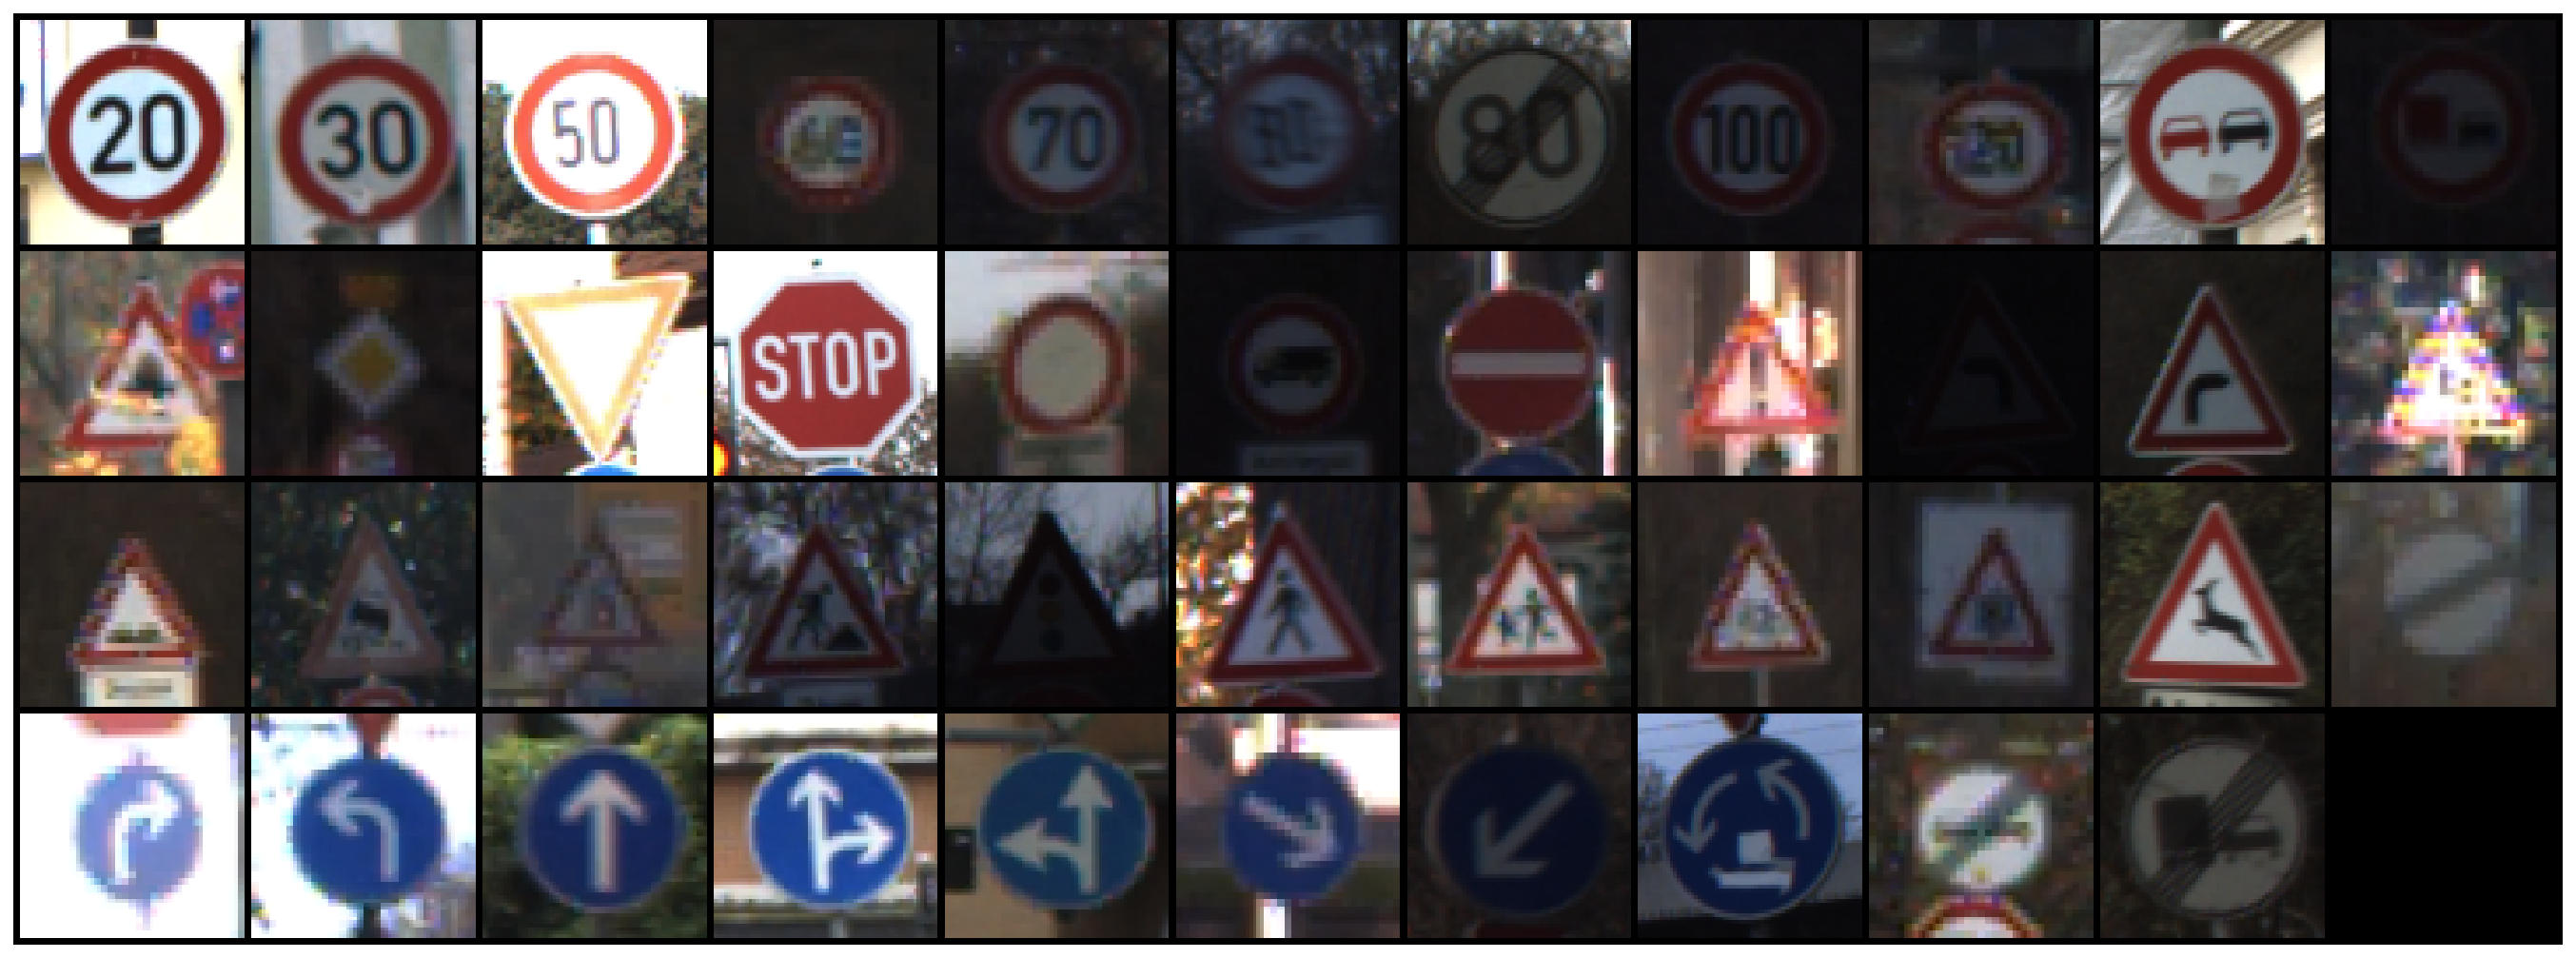

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

## Building a dataset



In [ ]:
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices = [12, 13, 14, 17]

We'll copy the images files to a new directory.

In [ ]:
!rm -rf data
DATA_DIR = Path('data')
DATASETS = ['train', 'val', 'test']
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

We'll reserve 80% of the images for training, 10% for validation, and 10% test for each class. We'll copy each image to the correct dataset directory:

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)
  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )
  dataset_data = zip(DATASETS, ds_split)
  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


We have some class imbalance, but it is not that bad. We'll ignore it.

We'll apply some image augmentation techniques to artificially increase the size of our training dataset:

In [ ]:

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

We apply some random resizing, rotation, and horizontal flips. Finally, we normalize the tensors using preset values for each channel. This is a [requirement of the pre-trained models](https://pytorch.org/docs/stable/torchvision/models.html) in Torchvision.

We'll create a PyTorch dataset for each image dataset folder and data loaders for easier training:

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}
data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

We'll also store the number of examples in each dataset and class names for later:

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes
dataset_sizes

{'test': 615, 'train': 4920, 'val': 615}

Let's have a look at some example images with applied transformations. We also need to reverse the normalization and reorder the color channels to get correct image data:

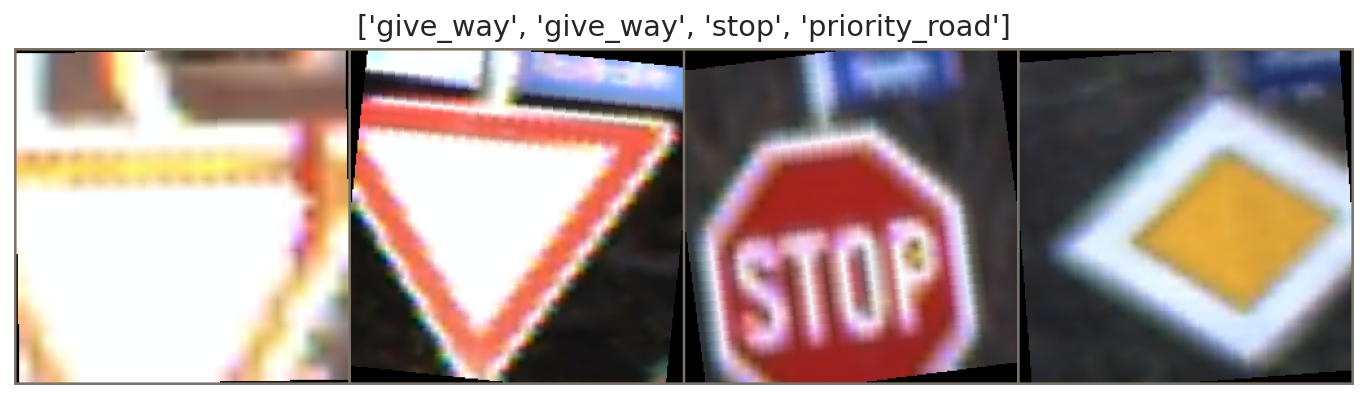

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')
inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Using a pre-trained model:



In [ ]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)
  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)
  return model.to(device)

We reuse almost everything except the change of the output layer. 

In [ ]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


### Training

We'll write 3 helper functions to encapsulate the training and evaluation logic. Let's start with `train_epoch`:

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  scheduler.step()
  return correct_predictions.double() / n_examples, np.mean(losses)

calculating the epoch loss and accuracy.


In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

The evaluation of the model is similar. 

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)
  history = defaultdict(list)
  best_accuracy = 0
  for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc
  print(f'Best val accuracy: {best_accuracy}')
  model.load_state_dict(torch.load('best_model_state.bin'))
  return model, history


Let's train our model:

In [ ]:
%%time
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device,n_epochs=5)

Epoch 1/5
----------
Train loss 0.33822687313502947 accuracy 0.8839430894308943
Val   loss 0.004010351626317361 accuracy 0.9983739837398374

Epoch 2/5
----------
Train loss 0.1447846091769913 accuracy 0.9546747967479675
Val   loss 0.01178960684856892 accuracy 0.9983739837398374

Epoch 3/5
----------
Train loss 0.07218948909994503 accuracy 0.9764227642276423
Val   loss 0.004156076648309981 accuracy 0.9983739837398374

Epoch 4/5
----------
Train loss 0.06318002283446619 accuracy 0.9796747967479674
Val   loss 0.0025829515615991387 accuracy 0.9983739837398374

Epoch 5/5
----------
Train loss 0.05210619329272293 accuracy 0.9841463414634146
Val   loss 0.0064140296462229145 accuracy 0.9983739837398374

Best val accuracy: 0.9983739837398374
CPU times: user 3min 7s, sys: 53 s, total: 4min
Wall time: 4min 6s


Here's a little helper function that visualizes the training history for us:

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')
  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  fig.suptitle('Training history')

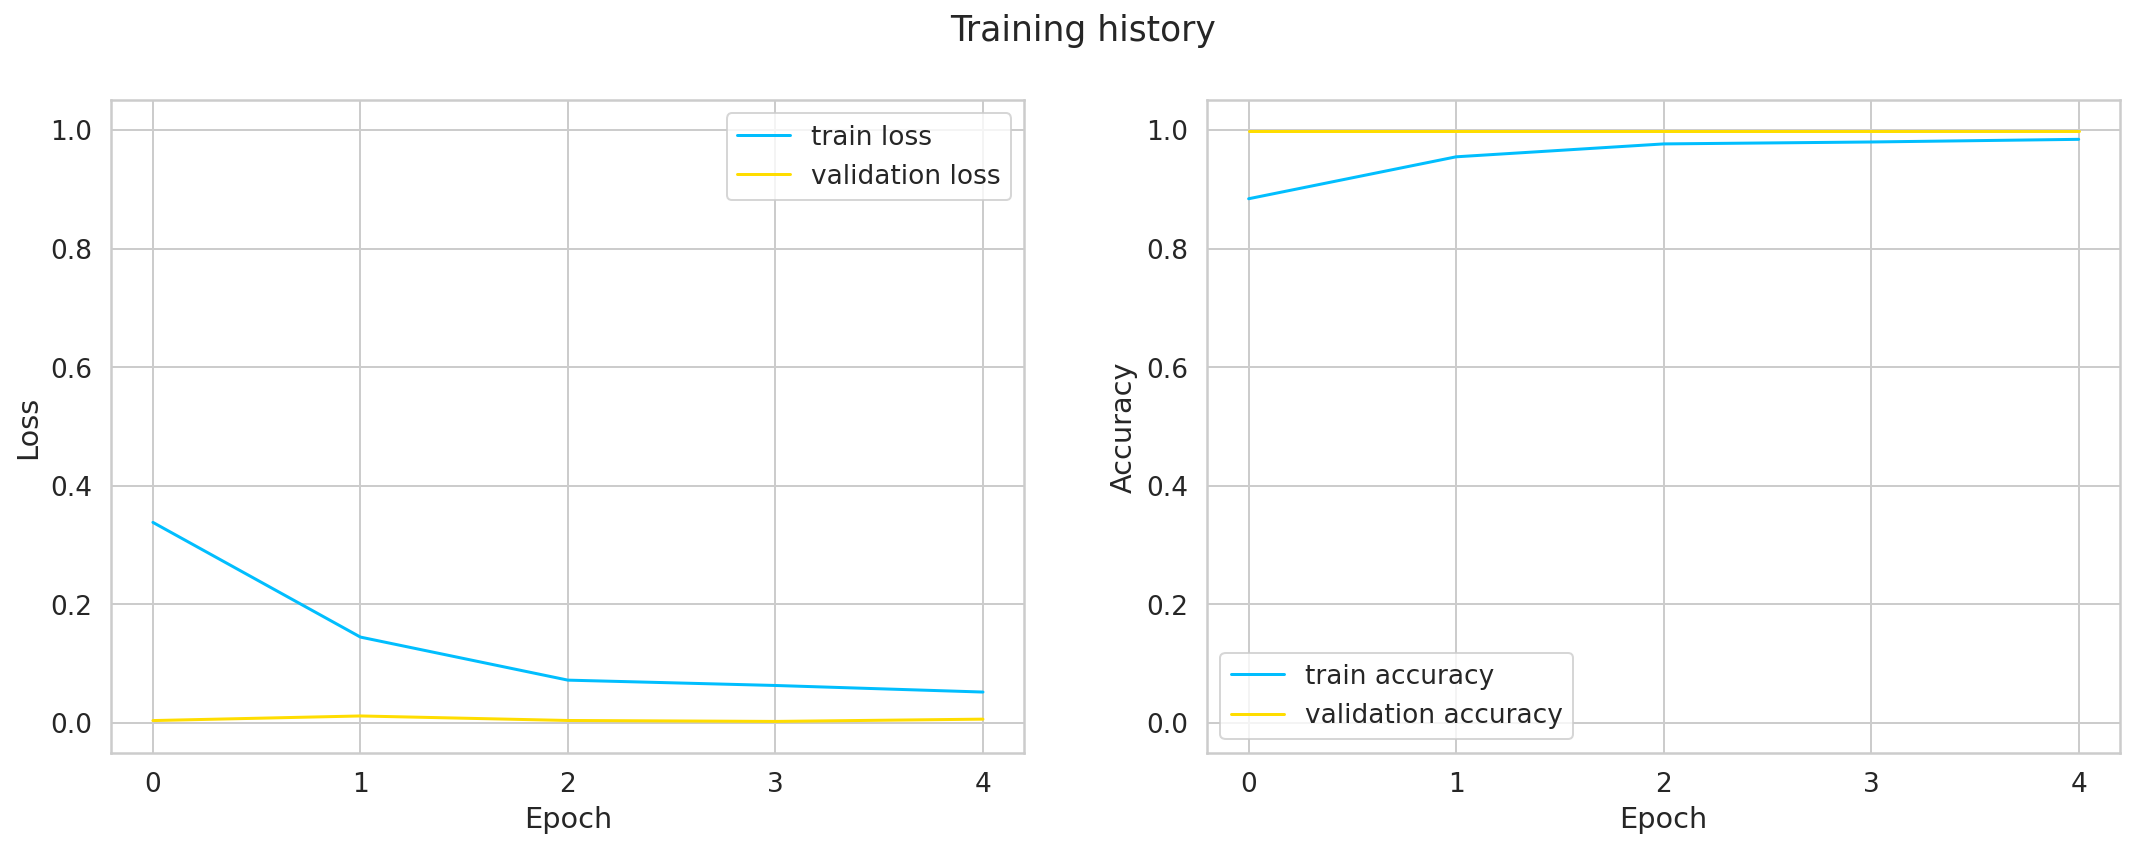

In [ ]:
plot_training_history(history)

The pre-trained model is so good that we get very high accuracy and low loss after 3 epochs. Unfortunately, our validation set is too small to get some meaningful metrics from it.

### Evaluation

Let's see some predictions on traffic signs from the test set:

In [ ]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')
        if images_handeled == n_images:
          return

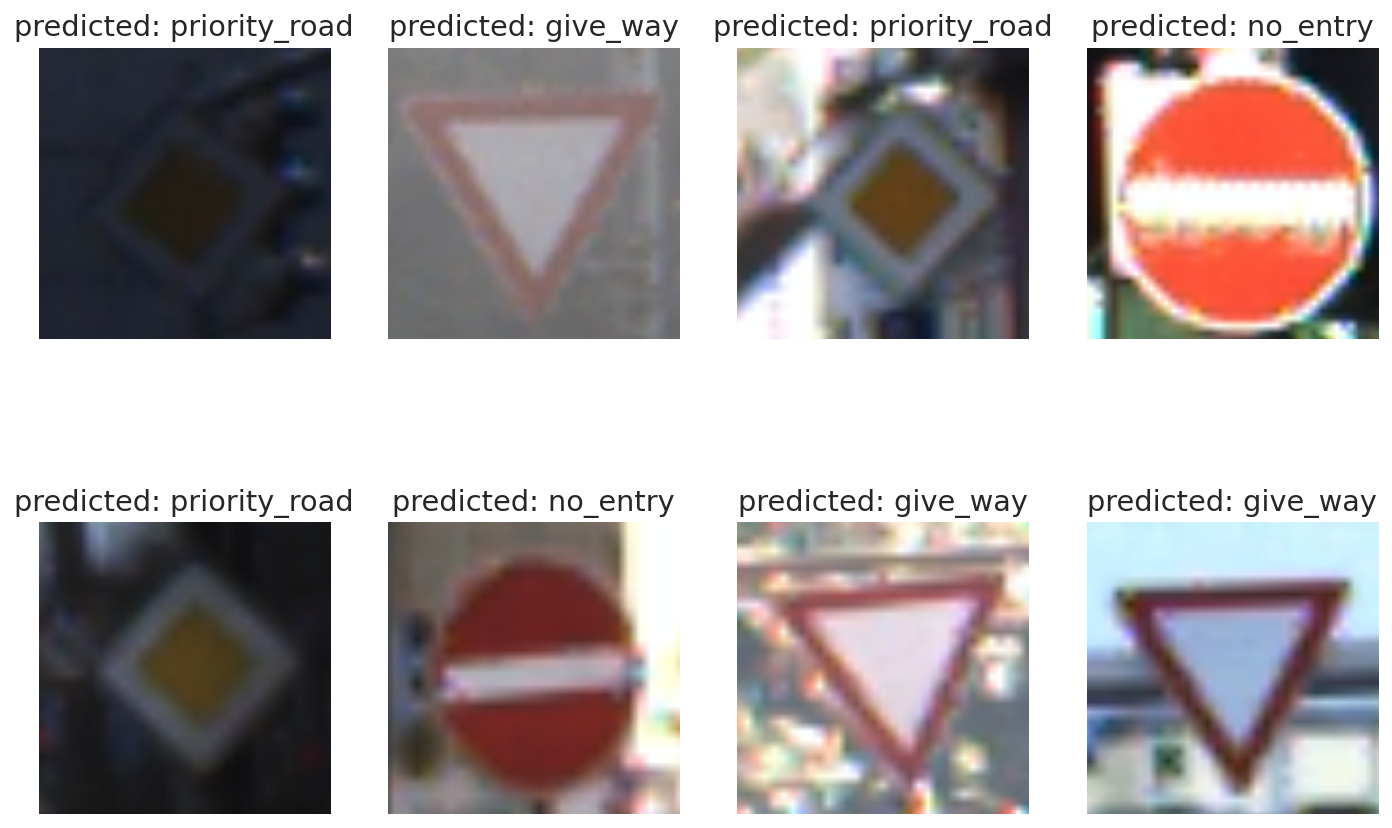

In [ ]:
show_predictions(base_model, class_names, n_images=8)



We'll start by getting the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      0.99      1.00       216
     no_entry       1.00      1.00      1.00       111
priority_road       1.00      1.00      1.00       210
         stop       0.99      1.00      0.99        78

     accuracy                           1.00       615
    macro avg       1.00      1.00      1.00       615
 weighted avg       1.00      1.00      1.00       615



The classification report shows us that our model is perfect, not something you see every day! Does this thing make any mistakes?

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):
  cm = confusion_matrix.copy()
  cell_counts = cm.flatten()
  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]
  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]
  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])
  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)
  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

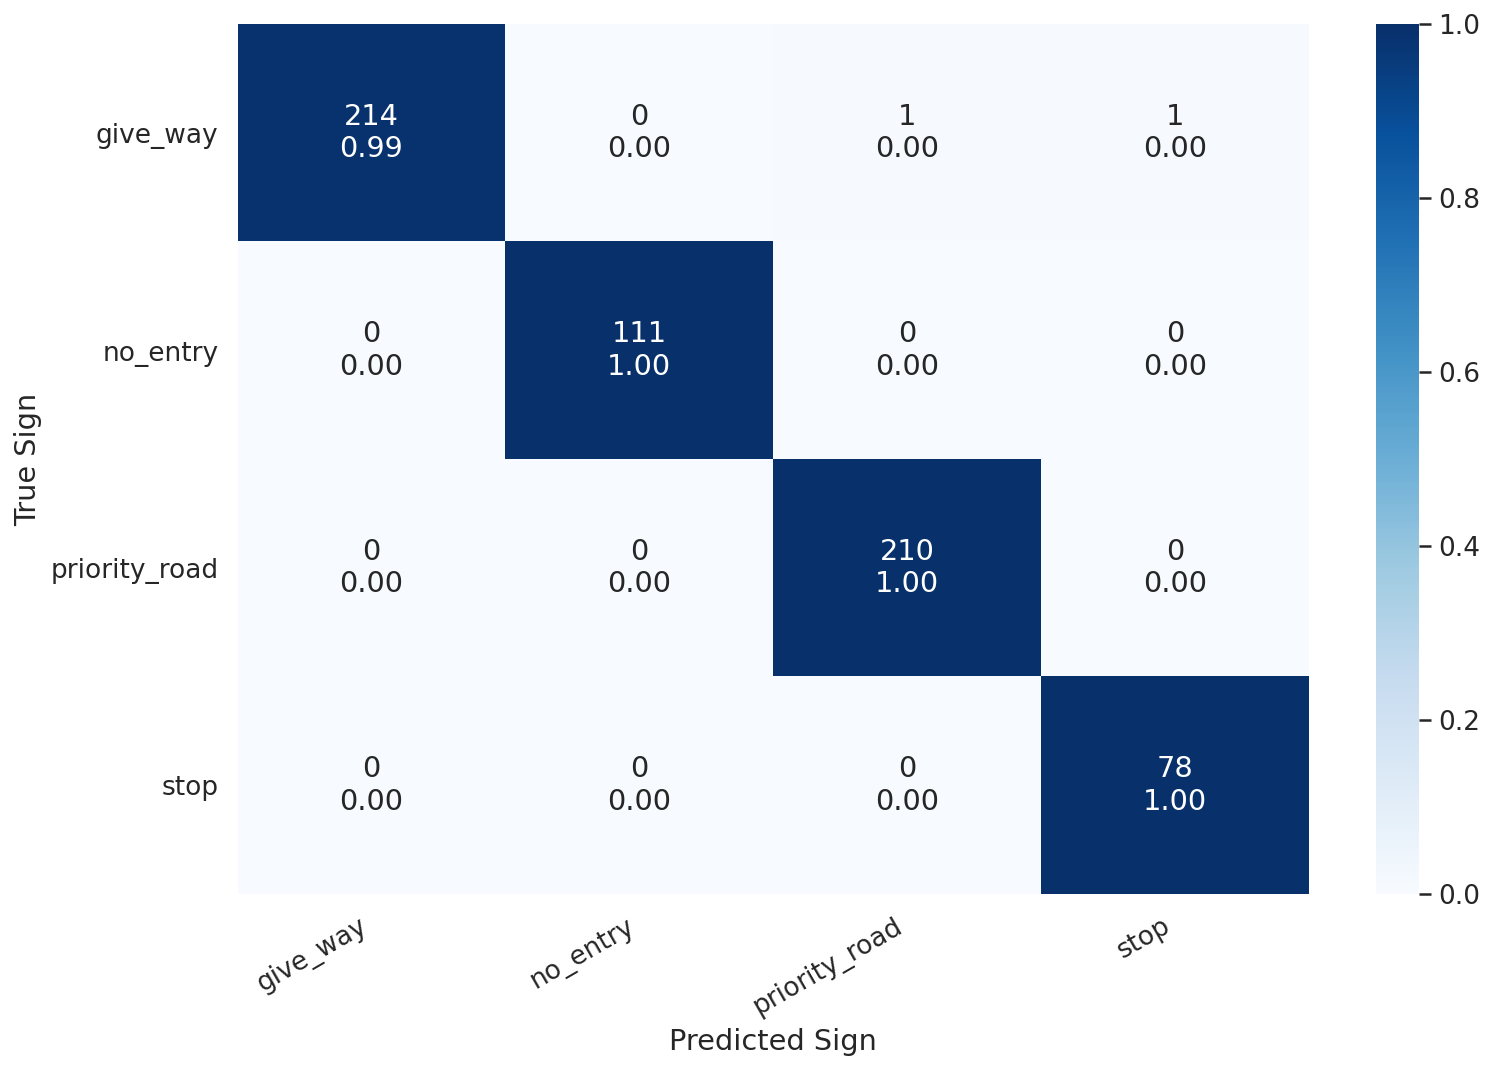

In [ ]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

### Classifying unseen images



In [ ]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr

Downloading...
From: https://drive.google.com/uc?id=19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
To: /content/stop-sign.jpg
100% 77.3k/77.3k [00:00<00:00, 5.15MB/s]


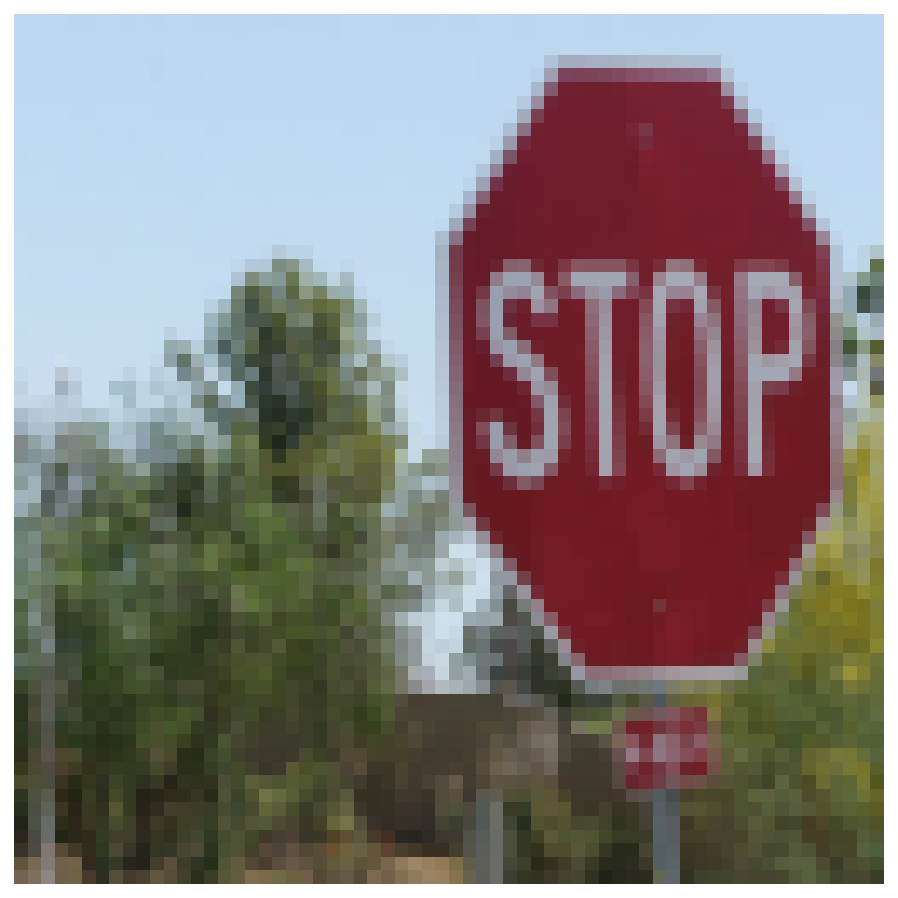

In [ ]:
show_image('stop-sign.jpg')

In [ ]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)
  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [ ]:
pred =  (base_model, 'stop-sign.jpg')
pred

array([2.9925426e-04, 5.7312613e-04, 1.0741598e-03, 9.9805343e-01],
      dtype=float32)

In [ ]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

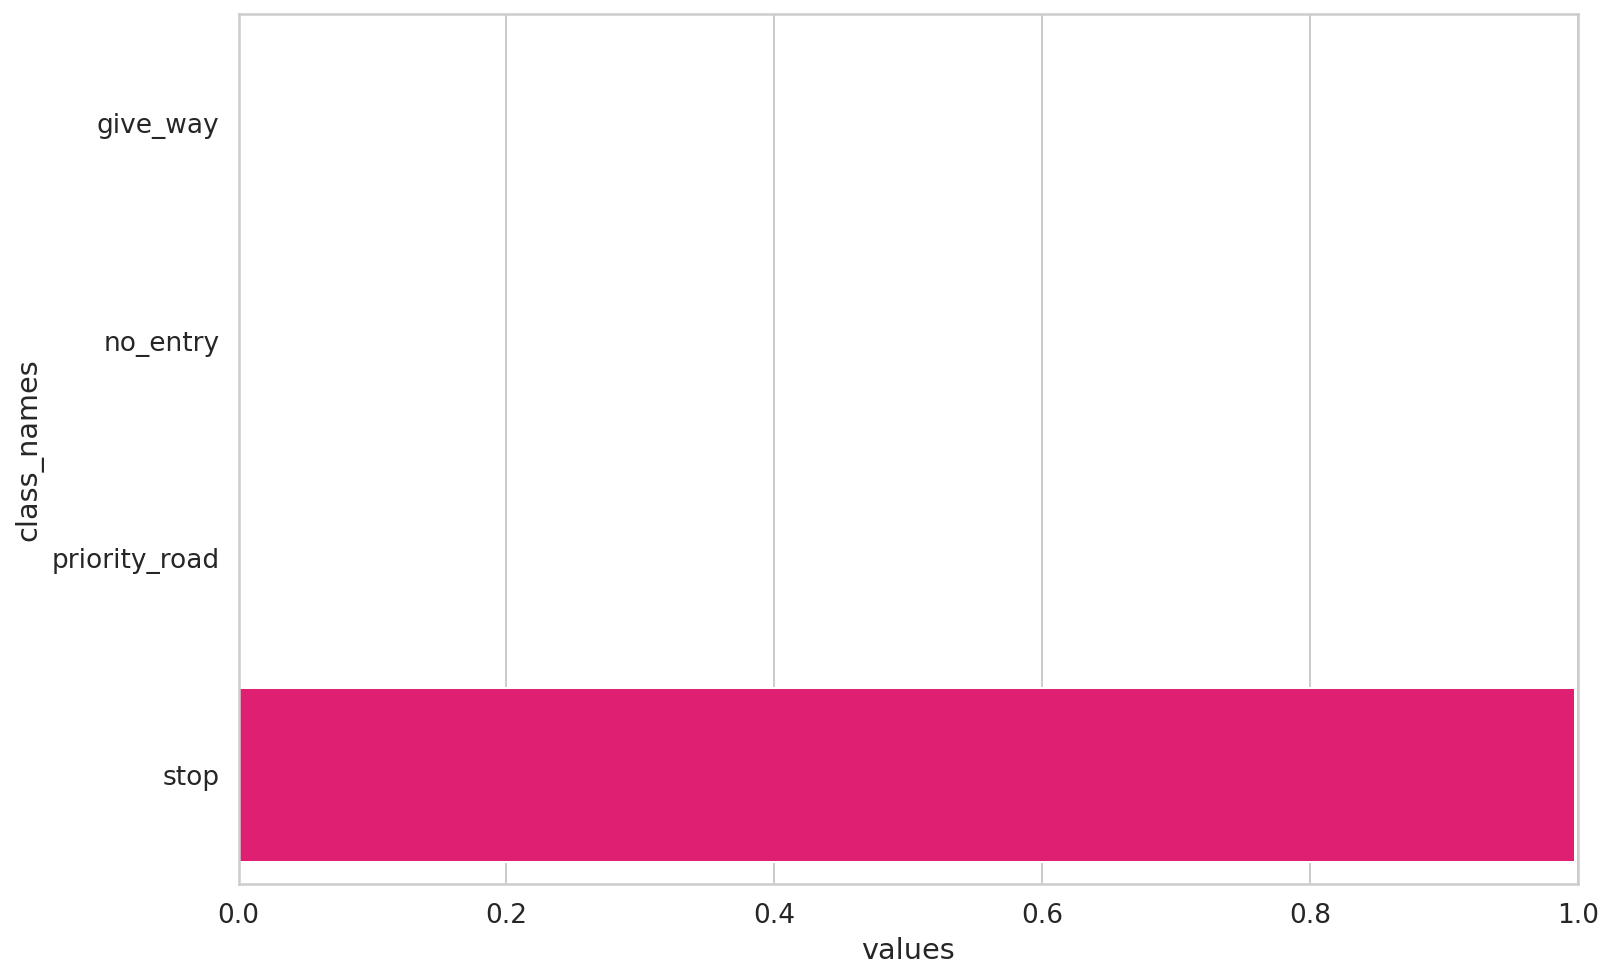

In [ ]:
show_prediction_confidence(pred, class_names)

### Classyfing unknown traffic sign

In [ ]:
!gdown --id 1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u

Downloading...
From: https://drive.google.com/uc?id=1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u
To: /content/unknown-sign.jpg
100% 41.4k/41.4k [00:00<00:00, 6.06MB/s]


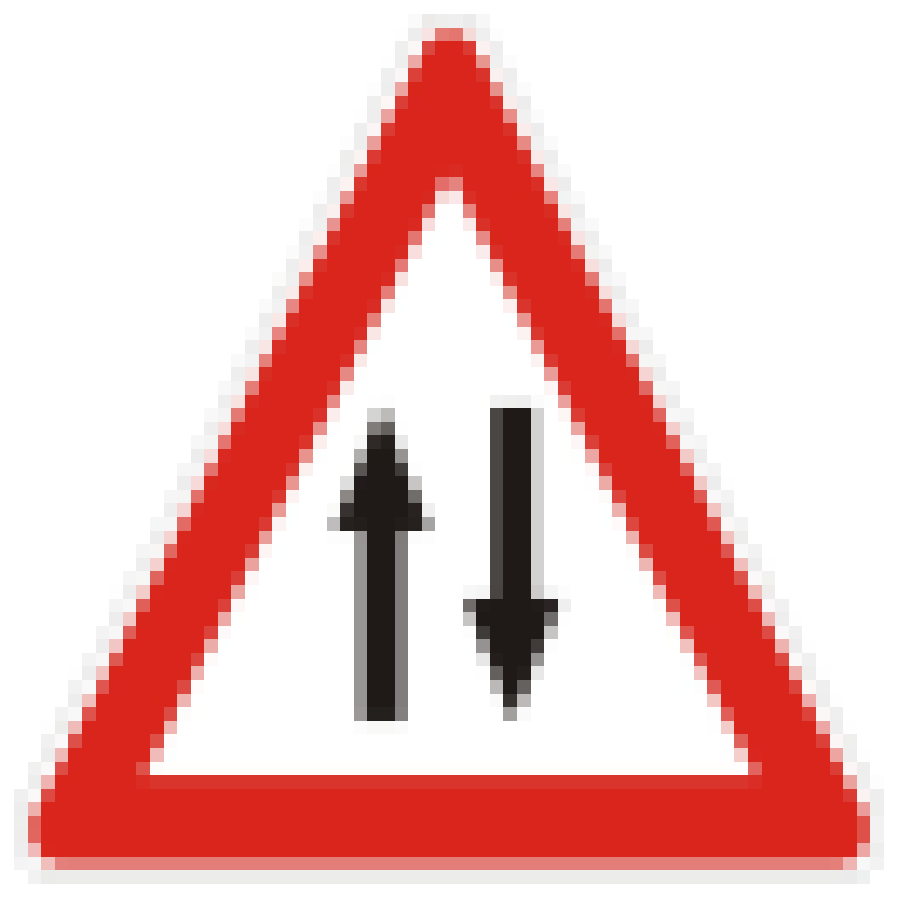

In [ ]:
show_image('unknown-sign.jpg')

Let's get the predictions:

In [ ]:
pred = predict_proba(base_model, 'unknown-sign.jpg')
pred

array([9.3119597e-01, 8.2524994e-04, 2.1777635e-03, 6.5801017e-02],
      dtype=float32)

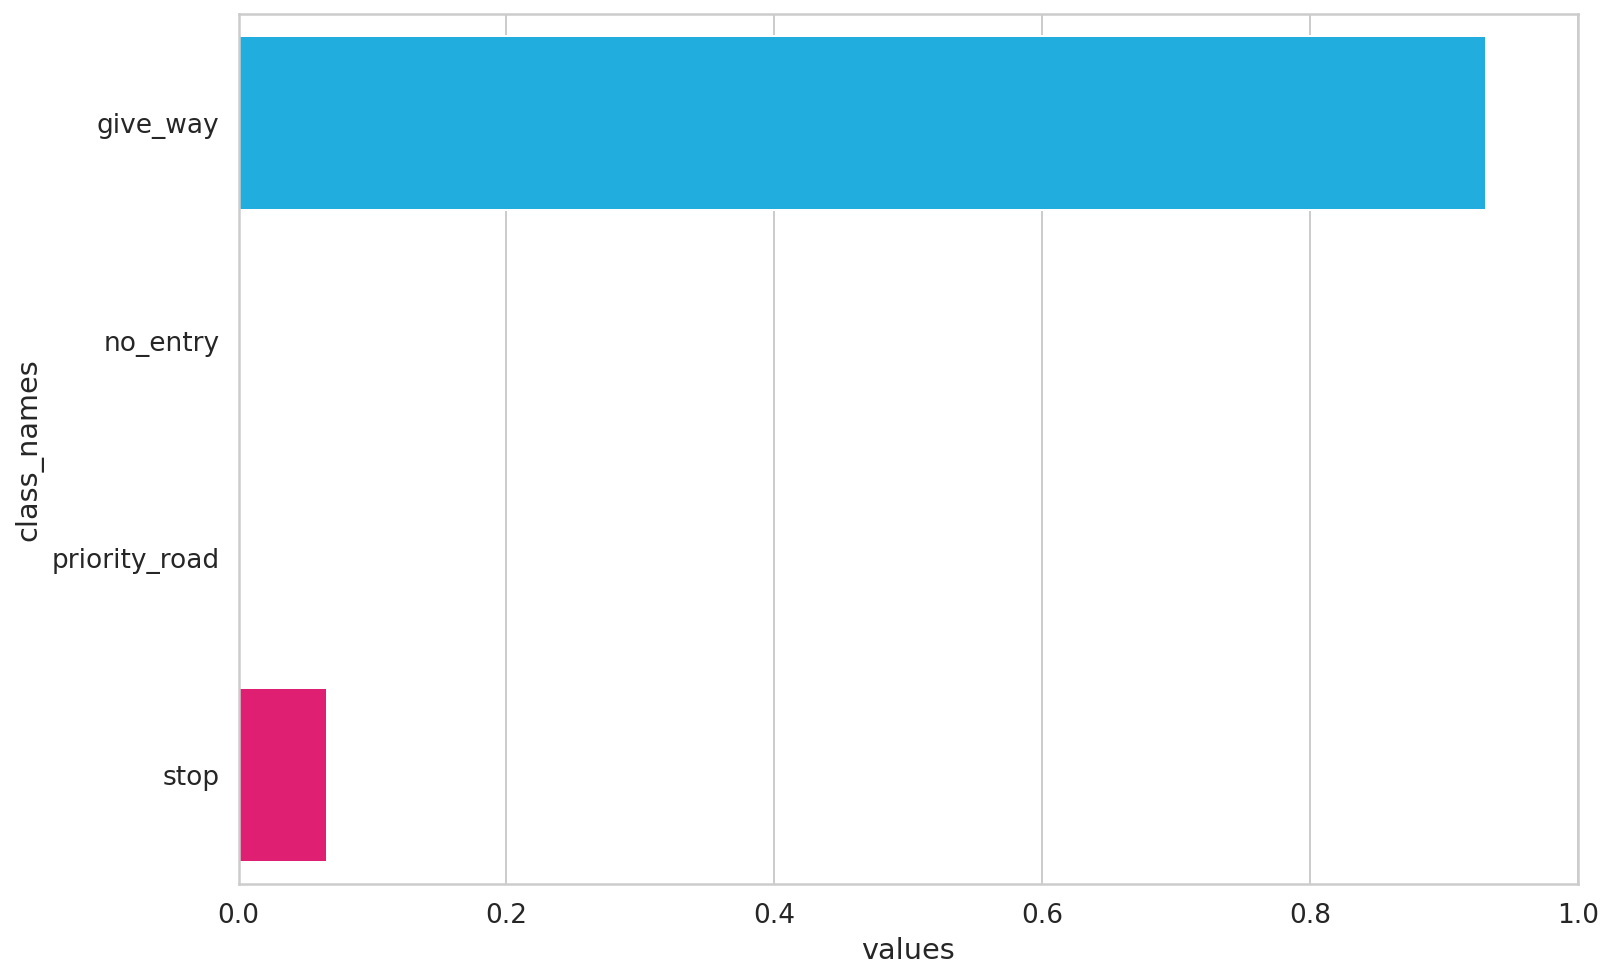

In [ ]:
show_prediction_confidence(pred, class_names)